In [2]:
import torch as T
import torchvision as TV
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# load data and check images

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [36]:
batch_size = 128
train_dataset = TV.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = TV.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [38]:
def show_image(img):
    img = img /2 + 0.5 # unnormalize
    npimg = img.numpy() # to array
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
data_iter = iter(train_dataloader) # to a generator
images, labels = data_iter.next()

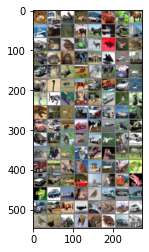

frog truck truck deer car car bird horse ship cat deer horse horse bird truck truck truck cat bird frog deer cat frog frog bird frog cat dog deer plane plane truck car cat deer plane cat horse cat cat dog bird bird horse car car car bird bird plane truck dog horse truck bird bird dog bird deer cat car car ship bird car car deer truck horse ship dog truck frog horse cat car truck plane cat car cat dog deer dog horse horse deer horse truck deer bird cat ship plane car frog car car deer car ship cat truck frog frog car ship dog bird truck truck ship car horse horse plane plane frog truck car bird bird truck bird frog frog car truck


In [39]:
show_image(TV.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(batch_size)))

# set up cuda 

In [40]:
device = T.device("cuda:0") if T.cuda.is_available() else "cpu"
print(device, type(device))

cuda:0 <class 'torch.device'>


# create model of CNN

In [58]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CovNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = T.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
model = CovNet()
model.to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


# loss function

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = T.optim.AdamW(model.parameters(), lr=0.001)

# training step

In [43]:
for epoch in range(10):
    running_loss = 0.0 
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
            
print("Finished Training")

Finished Training


In [46]:
PATH = os.path.join("./cifar_net.pth")
T.save(model.state_dict(), PATH)

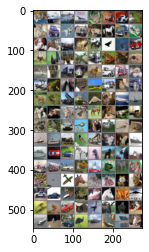

Ground Truth: cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship dog horse ship frog horse plane deer truck dog bird deer plane truck frog frog dog deer dog truck bird deer car truck dog deer frog dog frog plane truck cat truck horse frog truck ship plane cat ship ship horse horse deer frog horse cat frog cat frog bird car bird cat horse bird frog ship ship plane bird truck cat cat ship ship car car horse bird dog bird horse ship truck plane cat ship frog deer frog frog plane plane horse deer dog frog cat car car cat frog ship horse deer plane frog bird car cat plane deer bird horse ship cat car bird ship plane ship cat


In [47]:
data_iter = iter(test_dataloader)
images, labels = data_iter.next()

show_image(TV.utils.make_grid(images))
print("Ground Truth:", " ".join(f"{classes[labels[j]]}" for j in range(batch_size)))

In [48]:
model = CovNet()
model.load_state_dict(T.load(PATH))
model.eval()

CovNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
outputs = model(images)
# print(outputs)
# [classes[i] for i in T.argmax(outputs, dim=1)]
_, predicted = T.max(outputs, 1)
print(predicted)
print("predicted:", " ".join(f"{classes[i]}" for i in predicted))

tensor([3, 8, 8, 0, 6, 6, 2, 2, 3, 1, 0, 9, 5, 7, 9, 6, 3, 9, 8, 6, 7, 0, 0, 9,
        4, 3, 4, 0, 1, 6, 6, 2, 2, 3, 9, 1, 7, 9, 9, 5, 0, 6, 7, 6, 8, 9, 3, 3,
        4, 6, 9, 9, 6, 6, 8, 8, 7, 1, 5, 3, 7, 5, 1, 1, 6, 6, 1, 0, 3, 9, 4, 6,
        8, 8, 9, 2, 0, 3, 5, 8, 8, 1, 1, 7, 2, 7, 2, 8, 8, 9, 0, 4, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 7, 6, 3, 1, 1, 2, 6, 8, 5, 6, 0, 2, 2, 1, 3, 0, 3, 3, 3,
        0, 3, 1, 2, 8, 6, 0, 3])
predicted: cat ship ship plane frog frog bird bird cat car plane truck dog horse truck frog cat truck ship frog horse plane plane truck deer cat deer plane car frog frog bird bird cat truck car horse truck truck dog plane frog horse frog ship truck cat cat deer frog truck truck frog frog ship ship horse car dog cat horse dog car car frog frog car plane cat truck deer frog ship ship truck bird plane cat dog ship ship car car horse bird horse bird ship ship truck plane deer ship frog deer frog frog plane plane horse deer horse frog cat car car bird frog ship dog 

In [51]:
correct = 0
total = 0
with T.no_grad():
    for data in test_dataloader:
        images, labels = data
        logits = model(images)
        _, predicted = T.max(logits, 1)
        total += len(predicted)
        correct += (predicted==labels).sum().item()
print(f"{total} images are tested, {correct} images are correctly classified! Rate={correct/total*100:.2f}%")

10000 images are tested, 5972 images are correctly classified! Rate=59.72%


In [52]:
total_pred = {classname:0 for classname in classes}
correct_pred = {classname:0 for classname in classes}
with T.no_grad():
    for data in test_dataloader:
        images, labels = data
        logits = model(images)
        _, predicted = T.max(logits, 1)
        for label, pred in zip(labels, predicted):
            total_pred[classes[label]] += 1
            if label == pred:
                correct_pred[classes[pred]] += 1

print(" ".join(f"{classname}:{correct_pred[classname]/total_pred[classname]*100:.2f}%" for classname in total_pred ))
    
    


plane:71.90% car:80.20% bird:48.80% cat:47.50% deer:41.20% dog:36.70% frog:82.30% horse:60.60% ship:67.30% truck:60.70%
